# House Price Predictor

In [43]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

In [44]:
# -----------------------------
# 1. Load the dataset
# -----------------------------
# Replace 'house_prices.csv' with the path to your dataset.

#Only CPU available in codespaces
device = torch.device("cpu")

train_path = "/workspaces/houseprice-prediction-using-neural-nets-darsh-grewal/train.csv"
test_path = "/workspaces/houseprice-prediction-using-neural-nets-darsh-grewal/test.csv"

data = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Display basic information about the datasets
print("Training Data Overview:")
print(data.info())
print(data.head())

print("\nTest Data Overview:")
print(test.info())
print(test.head())


Training Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1000 non-null   int64  
 1   MSSubClass     1000 non-null   int64  
 2   MSZoning       1000 non-null   object 
 3   LotFrontage    827 non-null    float64
 4   LotArea        1000 non-null   int64  
 5   Street         1000 non-null   object 
 6   Alley          65 non-null     object 
 7   LotShape       1000 non-null   object 
 8   LandContour    1000 non-null   object 
 9   Utilities      1000 non-null   object 
 10  LotConfig      1000 non-null   object 
 11  LandSlope      1000 non-null   object 
 12  Neighborhood   1000 non-null   object 
 13  Condition1     1000 non-null   object 
 14  Condition2     1000 non-null   object 
 15  BldgType       1000 non-null   object 
 16  HouseStyle     1000 non-null   object 
 17  OverallQual    1000 non-null 

In [45]:
# -----------------------------
# 2. Data Cleaning
# -----------------------------
# Select only numeric columns that have no missing data.
numeric_cols = data.select_dtypes(include=[np.number]).columns
clean_numeric_cols = [col for col in numeric_cols if data[col].isna().sum() == 0]
data_clean = data[clean_numeric_cols]

# Ensure that the target column 'price' is present.
if 'SalePrice' not in data_clean.columns:
    raise ValueError("The target column 'price' is not present in the complete numeric data.")

Selected top 4 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']


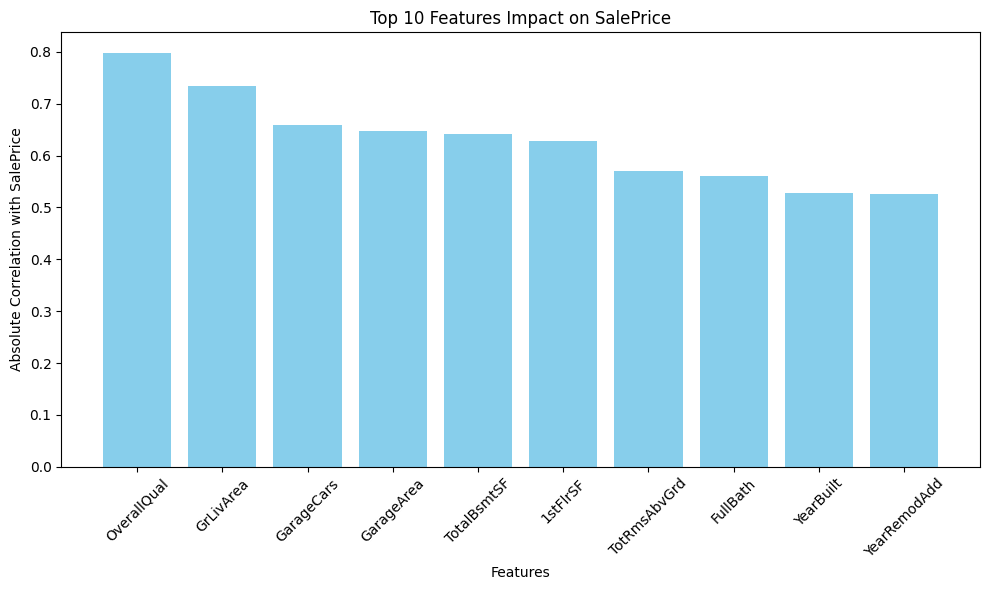

In [46]:
import matplotlib.pyplot as plt

# -----------------------------
# 3. Feature Selection
# -----------------------------

# Compute the correlation matrix using only the cleaned numeric data.
corr_matrix = data_clean.corr()

# Compute absolute correlations of features with the target and drop the target itself.
target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)

# Select only the top 4 features with the highest correlation with 'SalePrice'
top4_features = target_corr.head(4).index
print("Selected top 4 features:", list(top4_features))

# Define input features (X) and target variable (y) for the model.
X = data_clean[top4_features].values
y = data_clean['SalePrice'].values.reshape(-1, 1)

# -----------------------------
# Plotting the Top 10 Features Impact
# -----------------------------

# Get the top 10 features with the highest absolute correlations.
top10_features = target_corr.head(10)

# Create a bar plot for these top 10 features.
plt.figure(figsize=(10, 6))
plt.bar(top10_features.index, top10_features.values, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation with SalePrice')
plt.title('Top 10 Features Impact on SalePrice')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout for better fit
plt.show()


In [47]:
# -----------------------------
# 4. Data Preprocessing
# -----------------------------
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to improve training stability.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
# Convert the numpy arrays to PyTorch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset and DataLoader for batch processing.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [49]:
# -----------------------------
# 5. Define the Neural Network Model
# -----------------------------
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output layer for regression
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HousePriceModel(input_dim=X_train.shape[1]).to(device)

In [50]:
# -----------------------------
# 6. Set Up Loss Function and Optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# -----------------------------
# 7. Train the Model
# -----------------------------
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [10/1000], Loss: 7856600596.4800
Epoch [20/1000], Loss: 2396583459.8400
Epoch [30/1000], Loss: 1740360988.1600
Epoch [40/1000], Loss: 1589655623.6800
Epoch [50/1000], Loss: 1521347056.6400
Epoch [60/1000], Loss: 1470206635.5200
Epoch [70/1000], Loss: 1447135723.5200
Epoch [80/1000], Loss: 1422017966.0800
Epoch [90/1000], Loss: 1409483517.4400
Epoch [100/1000], Loss: 1411634492.1600
Epoch [110/1000], Loss: 1389169425.9200
Epoch [120/1000], Loss: 1390359845.1200
Epoch [130/1000], Loss: 1382115475.2000
Epoch [140/1000], Loss: 1370746540.8000
Epoch [150/1000], Loss: 1377838013.4400
Epoch [160/1000], Loss: 1377640936.9600
Epoch [170/1000], Loss: 1371834504.9600
Epoch [180/1000], Loss: 1373672939.5200
Epoch [190/1000], Loss: 1365380815.3600
Epoch [200/1000], Loss: 1358431857.9200
Epoch [210/1000], Loss: 1360669688.3200
Epoch [220/1000], Loss: 1363402967.0400
Epoch [230/1000], Loss: 1355331473.9200
Epoch [240/1000], Loss: 1368948743.6800
Epoch [250/1000], Loss: 1359874005.7600
Epoch [26

In [51]:
# 8. Evaluate the Model
# -----------------------------
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.to(device))
    test_loss = criterion(predictions, y_test_tensor.to(device)).item()
    print("Test Mean Squared Error:", test_loss)

# Optionally, to evaluate using scikit-learn's MSE:
predictions_np = predictions.cpu().numpy()
mse = mean_squared_error(y_test, predictions_np)
print("Test MSE (scikit-learn):", mse)

Test Mean Squared Error: 899562240.0
Test MSE (scikit-learn): 899562240.0


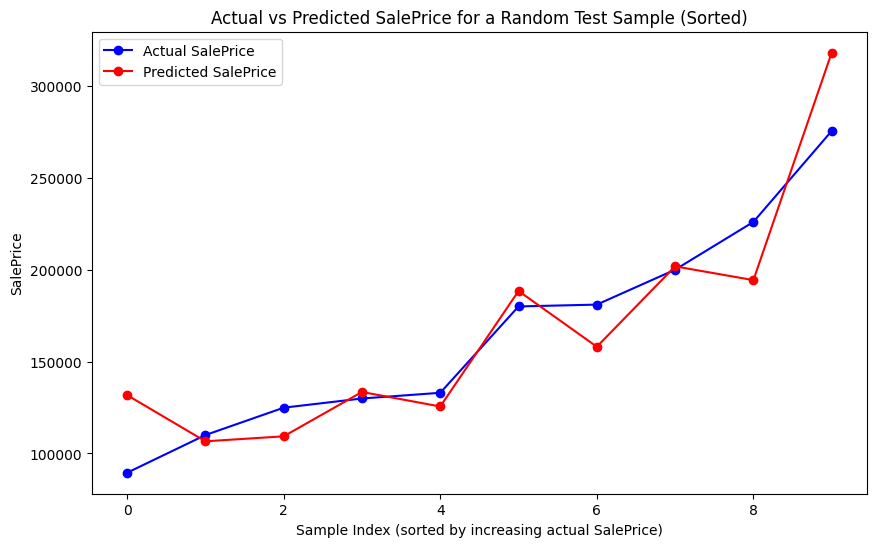

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a random subset of indices from the test set (e.g., 10 random samples)
sample_size = 10
sample_indices = np.random.choice(len(y_test_tensor), size=sample_size, replace=False)

# Get the corresponding test inputs and targets
sample_X = X_test_tensor[sample_indices].to(device)
sample_y = y_test_tensor[sample_indices].to(device)

# Evaluate the model on this random sample
model.eval()
with torch.no_grad():
    sample_predictions = model(sample_X)

# Convert predictions and actual values to NumPy arrays for plotting
sample_predictions_np = sample_predictions.cpu().numpy().flatten()
sample_y_np = sample_y.cpu().numpy().flatten()

# Sort the samples by increasing actual sale price
sorted_indices = np.argsort(sample_y_np)
sample_y_sorted = sample_y_np[sorted_indices]
sample_predictions_sorted = sample_predictions_np[sorted_indices]

# Plot the sorted actual vs predicted sale prices
plt.figure(figsize=(10, 6))
plt.plot(sample_y_sorted, 'bo-', label='Actual SalePrice')
plt.plot(sample_predictions_sorted, 'ro-', label='Predicted SalePrice')
plt.xlabel('Sample Index (sorted by increasing actual SalePrice)')
plt.ylabel('SalePrice')
plt.title('Actual vs Predicted SalePrice for a Random Test Sample (Sorted)')
plt.legend()
plt.show()


The loss values were quiet large, so I made this plot to see if it's just because the sale prices are a big number. Seems like the prediction's aren't too shabby. I tried to change the hyperparameters around to get better results, but no major changes appeared.

In [55]:
#Making predictions.csv
test_data = pd.read_csv("test.csv")

# Extract the ID column and the features used for prediction.
test_ids = test_data['Id']
test_features = test_data[top4_features].values.astype(np.float32)

# Convert the test features to a tensor (ensure the data type matches training, e.g., float32)
test_tensor = torch.tensor(test_features, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predictions = model(test_tensor)

# Convert predictions to numpy array
predictions_np = predictions.cpu().numpy()

# -----------------------------
# Create and Save Predictions CSV
# -----------------------------
# Ensure that ID is of type int and SALEPRICE is a float.
predictions_df = pd.DataFrame({
    "Id": test_ids.astype(int),
    "SalePrice": predictions_np.flatten().astype(float)
})

# Save the predictions to a CSV file without the index.
predictions_df.to_csv("predictions.csv", index=False)

print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv
